In [ ]:
!pip install openai tqdm anthropic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.0/264.0 kB 5.2 MB/s eta 0:00:00


In [ ]:
import json
import os
import time
from openai import OpenAI
from google.colab import userdata
import subprocess
import tempfile
import concurrent.futures
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
openai_client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))
anthropic_client = OpenAI(api_key=userdata.get('ANTHROPIC_API_KEY'), base_url="https://api.anthropic.com/v1/")
xai_client = OpenAI(api_key=userdata.get("XAI_API_KEY"), base_url="https://api.x.ai/v1")

In [ ]:
HUMANEVAL_PATH = "HumanEvalPlus.jsonl"
if not os.path.exists(HUMANEVAL_PATH):
    raise FileNotFoundError(f"{HUMANEVAL_PATH} not found")

In [ ]:
def load_humaneval_data(file_path=HUMANEVAL_PATH):
    problems = []
    with open(file_path, 'r') as f:
        for line in f:
            problems.append(json.loads(line))
    print(f"Loaded {len(problems)} problems from {file_path}")
    return problems

In [ ]:
import re
import time
from typing import Optional

def _seconds_from_msg(msg):
    match = re.search(r'Please try again in ([\dhms]+)\.', msg)
    if not match:
        return 30

    total = 0
    for value, unit in re.findall(r'(\d+)([hms])', match.group(1)):
        n = int(value)
        total += n * {'h': 3600, 'm': 60, 's': 1}[unit]
    return total or 30

def generate_code(model_type, prompt, max_tokens=1024, temperature=1.0, max_retries=3):
    model_map = {
        "o3": ("o3", openai_client),
        "claude": ("claude-3-7-sonnet-20250219", anthropic_client),
        "grok": ("grok-3-latest", xai_client),
    }

    if model_type not in model_map:
        raise ValueError(f"Unknown model: {model_type}")

    model, client = model_map[model_type]

    for attempt in range(1, max_retries + 1):
        try:
            completion = client.chat.completions.create(
                model=model,
                messages=[
                    {
                        "role": "system",
                        "content": (
                            "You are an AI assistant that generates Python code. "
                            "Only provide the code implementation without any explanations or comments. "
                            "Make sure your code includes all imports and is compilable."
                        ),
                    },
                    {
                        "role": "user",
                        "content": f"Complete the following Python function:\n\n{prompt}",
                    },
                ],
                max_completion_tokens=max_tokens,
                temperature=temperature,
                n=1,
            )
            return completion.choices[0].message.content

        except Exception as e:
            err_msg = str(e)
            if "code: 429" in err_msg and "rate limit" in err_msg.lower():
                wait_s = _seconds_from_msg(err_msg)
                print(
                    f"[attempt {attempt}/{max_retries}] "
                    f"Rate-limit hit. Sleeping {wait_s} s before retrying…"
                )
                time.sleep(wait_s)
                continue
            else:
                print(f"Error generating code: {err_msg}")
                return None

    print("Error generating code: maximum retries exceeded.")
    return None

In [ ]:
def extract_code(response):
    if response is None:
        return None

    if "```python" in response and "```" in response:
        code_blocks = response.split("```")
        for i, block in enumerate(code_blocks):
            if i % 2 == 1:
                if block.startswith("python"):
                    block = block[6:]
                return block.strip()

    return response.strip()

In [ ]:
import signal, traceback

def execute_solution(problem, solution, timeout=10.0):
    def _time_out(signum, frame):
        raise TimeoutError("execution timed out")
    signal.signal(signal.SIGALRM, _time_out)
    signal.alarm(int(timeout))

    ns: dict = {}
    err = None
    passed = False

    try:
        exec(solution, ns)
        ns["candidate"] = ns[problem["entry_point"]]
        exec(problem["test"], ns)
        ns["check"](ns["candidate"])
        passed = True
    except Exception as e:
        err = traceback.format_exc()
    finally:
        signal.alarm(0)
    return passed, err

In [ ]:
def process_problem(problem, model):
    task_id = problem['task_id']
    print(f"Processing {task_id}...")

    prompt = problem["prompt"]
    response = generate_code(model, prompt)
    code = extract_code(response)

    passed, error = execute_solution(problem, code)

    return {
        'task_id': task_id,
        'passed': passed,
        'error': error,
        'generated_code': code
    }

In [ ]:
def run_benchmark(problems, model, problem_delay=1):
    print(f"Processing {len(problems)} problems for {model}")

    results = []
    start_time = time.time()

    for problem in tqdm(problems, desc=f"Running {model}"):
        result = process_problem(problem, model)
        results.append(result)
        if problem_delay > 0:
            time.sleep(problem_delay)

    elapsed_time = time.time() - start_time

    pass_count = sum(1 for r in results if r['passed'])
    pass_at_1 = pass_count / len(problems)

    print(f"\nBenchmark for {model} completed in {elapsed_time:.2f} seconds")
    print(f"Pass@1: {pass_at_1:.4f} ({pass_count}/{len(problems)})")

    results_file = f'{model}_humaneval_results.json'
    with open(results_file, 'w') as f:
        json.dump({
            'model': model,
            'pass_at_1': pass_at_1,
            'num_problems': len(problems),
            'elapsed_time': elapsed_time,
            'results': results
        }, f, indent=2)

    print(f"Results saved to {results_file}")

    return results, pass_at_1, elapsed_time

In [ ]:
def run_full_benchmark(problems, models=['claude', 'grok', 'o3']):
    results = {}

    for model in models:
        if os.path.isfile(f'{model}_humaneval_results.json'):
            loaded_results = json.load(open(f'{model}_humaneval_results.json'))
            results[model] = {'pass_rate': loaded_results['pass_at_1'], 'elapsed_time': loaded_results['elapsed_time']}
            print(f"Loaded results for {model} from file")
            continue
        print(f"\n=== Running benchmark for {model} ===\n")
        _, pass_rate, elapsed_time = run_benchmark(problems, model)
        results[model] = {'pass_rate': pass_rate, 'elapsed_time': elapsed_time}

    model_names = list(results.keys())
    pass_rates = [results[model]['pass_rate'] * 100 for model in model_names]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(model_names, pass_rates)

    for bar, rate in zip(bars, pass_rates):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f"{rate:.1f}%", ha='center', va='bottom')

    plt.xlabel('Model')
    plt.ylabel('Pass Rate (%)')
    plt.title('HumanEval Pass@1 Results by Model')
    plt.ylim(0, 110)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('model_comparison.png')

    results_df = pd.DataFrame({
        'Model': model_names,
        'Pass Rate (%)': [f"{results[model]['pass_rate'] * 100:.2f}%" for model in model_names],
        'Elapsed Time (s)': [f"{results[model]['elapsed_time']:.2f}" for model in model_names]
    })

    return results_df

Loaded 164 problems from HumanEvalPlus.jsonl
Loaded results for claude from file
Loaded results for grok from file
Loaded results for o3 from file

=== Benchmark Results ===

 Model Pass Rate (%) Elapsed Time (s)
claude        85.37%           656.74
  grok        82.32%           755.72
    o3        88.41%          1833.32

Results saved to benchmark_results.csv


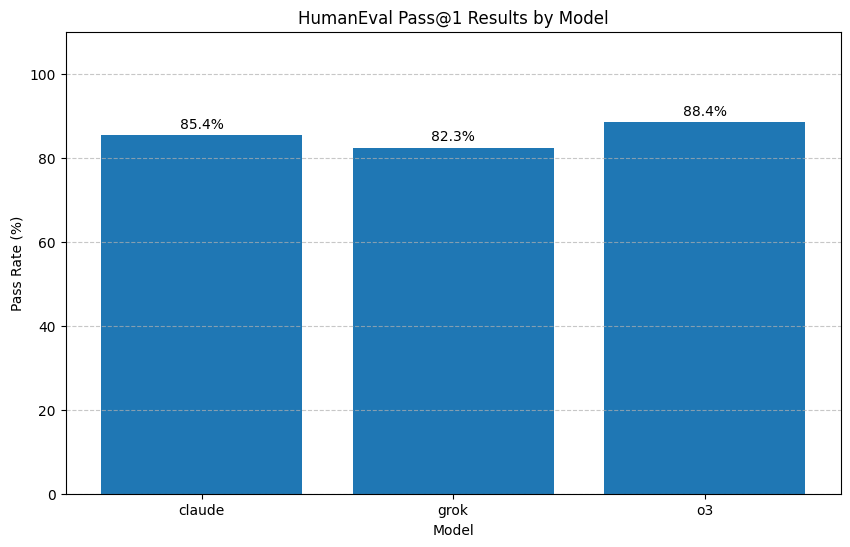

In [ ]:
problems = load_humaneval_data()
results_df = run_full_benchmark(problems)

print("\n=== Benchmark Results ===\n")
print(results_df.to_string(index=False))

results_df.to_csv('benchmark_results.csv', index=False)
print("\nResults saved to benchmark_results.csv")